Implementing a GAN network to create fake faces using a dataset of celebrities

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
import os
import gzip
import tarfile
import gc
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
from IPython.core.ultratb import AutoFormattedTB

In [2]:
#Get teh celebrity dataset
class CelebaDataset(Dataset):
    def __init__(self, root, size=128, train=True):
        super(CelebaDataset, self).__init__()
        root = os.path.join(root, 'test')
        self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root),transform = torchvision.transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()]))
    
    def __getitem__(self, index):
        img = self.dataset_folder[index]
        return img[0]
    
    def __len__(self):
        return len(self.dataset_folder)

In [ ]:
#The generator neural net
class Gen(nn.Module):
    def __init__(self, dataset):
        super(Gen, self).__init__()
        self.conn = nn.Linear(100,16* 1024)
        self.trans1 = nn.ConvTranspose2d(1024,512,kernel_size = 2, stride = 2, padding = 0)
        self.trans2 = nn.ConvTranspose2d(512,256,kernel_size = 2, stride = 2, padding = 0)
        self.trans3 = nn.ConvTranspose2d(256,128,kernel_size = 2, stride = 2, padding = 0)
        self.trans4 = nn.ConvTranspose2d(128,64,kernel_size = 2, stride = 2, padding = 0)
        self.trans5 = nn.ConvTranspose2d(64, 3, kernel_size = 2, stride = 2, padding = 0)
        self.net = nn.Sequential(
            self.trans1, 
            nn.BatchNorm2d(512), 
            nn.ReLU(),
            self.trans2, 
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            self.trans3, 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            self.trans4, 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            self.trans5, 
            nn.Sigmoid())
        
    def forward(self, x):
        self.lin_out = self.conn(x)
        self.lin_out = self.lin_out.view(-1,1024,4,4)
        return(self.net(self.lin_out))

#The discriminator neural net    
class Disc(nn.Module):
    def __init__(self, dataset):
        super(Disc, self).__init__()
        self.conv1 = nn.Conv2d(3,512,kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(512,256,kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(256,128,kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(128,64,kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(64,2,kernel_size = 3, stride = 1, padding = 1)
        self.net = nn.Sequential(
            self.conv1, 
            nn.LeakyReLU(.2),
            self.conv2, 
            #nn.BatchNorm2d(256), 
            nn.LeakyReLU(.2),
            self.conv3, 
            #nn.BatchNorm2d(128), 
            nn.LeakyReLU(.2),
            self.conv4, 
            #nn.BatchNorm2d(64), 
            nn.LeakyReLU(.2), 
            self.conv5)
        self.linear = nn.Linear(batch_size*2*128*128,1)
    
        
    def forward(self, x):
        out = self.net(x)
        out = out.view(-1,batch_size*2*128*128)
        out = self.linear(out)
        return(out)


#Get the dataset and set the parameters
train_dataset = CelebaDataset('/home/mark',train=True)
beta1 = .5
beta2 = .9
batch_size = 10

#Instantiate the models
model_gen = Gen(train_dataset)
model_disc = Disc(train_dataset)
model_gen = model_gen.cuda()
model_disc = model_disc.cuda()

#Set up the optimizers and data
optimizer_gen = optim.Adam(model_gen.parameters(), lr=2e-4, betas = (beta1, beta2))
optimizer_disc = optim.Adam(model_disc.parameters(), lr=2e-4, betas = (beta1,beta2))
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
gc.collect()

#Set the amount of epochs
epoch_length = 70
past = 0
loop = tqdm(total=200*epoch_length, position=0)
n_critic = 1
lam = 10

for epoch in range(epoch_length):
    counter = 1
    for x in train_loader:
        x = x.cuda(async=True)
        gc.collect()
        if counter > 200:
            break
        #Require changing the discriminator at the beginning of each batch
        for p in model_disc.parameters():
            p.requires_grad = True
        
        #Start the loop for how many times to run and update the discriminator
        for t in range(n_critic):
            optimizer_disc.zero_grad()
            
            #Get an epsilon 
            eps = torch.randn((batch_size,1), requires_grad=True)
            eps = eps.expand(batch_size, x.nelement()//batch_size)
            eps = eps.contiguous()
            eps = eps.view(batch_size, 3, 128, 128)
            eps = eps.cuda()
            
            #Get some z_noise to put into the generator
            z_noise = torch.randn((batch_size,100), requires_grad = True).cuda()
            x_t = model_gen(z_noise).data
            
            #Calculate the x_hat using the epsilon that we got earlier
            x_hat = (eps*x) + (1-eps)*x_t
            
            #Calculate the loss and update the discriminator
            d_loss = (model_disc(x_t) - model_disc(x) + (lam*((torch.norm(autograd.grad(model_disc(x_hat),x_hat)[0])) - 1)**2))
            d_loss = torch.mean(d_loss)
            d_loss.backward()
            optimizer_disc.step()
            
        #After this loop, turn off the updates of the discriminator
        for p in model_disc.parameters():
            p.requires_grad = False
        
        #Get the loss for the generator and update
        optimizer_gen.zero_grad()
        z_noise = torch.randn((batch_size,100)).cuda()
        g_loss = model_disc(model_gen(z_noise))
        g_loss = -torch.mean(g_loss)
        g_loss.backward()
        optimizer_gen.step()
        
        #Update the loop
        loop.set_description('Epoch:{:.4f}'.format(epoch+1))
        loop.update(1)
        my_pic = model_gen(torch.randn((1,100)).cuda())
        counter +=1
    
    #Show the images we get each epoch
    plt.imshow(my_pic.view(3,128,128).permute(1,2,0).detach())
    plt.show()
        




loop.close() 

In [8]:
#This model takes a long time to run, so safe all of the parameters and load them up when you want.

#torch.save(model_gen.state_dict(), '/home/mark/gen')
#torch.save(model_disc.state_dict(), '/home/mark/disc')
model_gen.load_state_dict(torch.load('/home/mark/gen'))
model_disc.load_state_dict(torch.load('/home/mark/disc'))

## Random Pictures

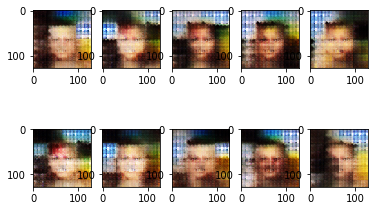

<Figure size 576x1152 with 0 Axes>

In [5]:
fig, axes= plt.subplots(2,5)
interp_list = []

#Plot 10 random images using a random vector
for i in range(10):
    my_pic = model_gen(torch.randn((1,100)).cuda())
    interp_list.append(my_pic)

axes[0,0].imshow(interp_list[0].view(3,128,128).permute(1,2,0).detach())
axes[0,1].imshow(interp_list[1].view(3,128,128).permute(1,2,0).detach())
axes[0,2].imshow(interp_list[2].view(3,128,128).permute(1,2,0).detach())
axes[0,3].imshow(interp_list[3].view(3,128,128).permute(1,2,0).detach())
axes[0,4].imshow(interp_list[4].view(3,128,128).permute(1,2,0).detach())
axes[1,0].imshow(interp_list[5].view(3,128,128).permute(1,2,0).detach())
axes[1,1].imshow(interp_list[6].view(3,128,128).permute(1,2,0).detach())
axes[1,2].imshow(interp_list[7].view(3,128,128).permute(1,2,0).detach())
axes[1,3].imshow(interp_list[8].view(3,128,128).permute(1,2,0).detach())
axes[1,4].imshow(interp_list[9].view(3,128,128).permute(1,2,0).detach())
plt.figure(figsize=(8,16)) 
plt.show()

## Photo Interpolation    

Populating the interactive namespace from numpy and matplotlib


/home/mark/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


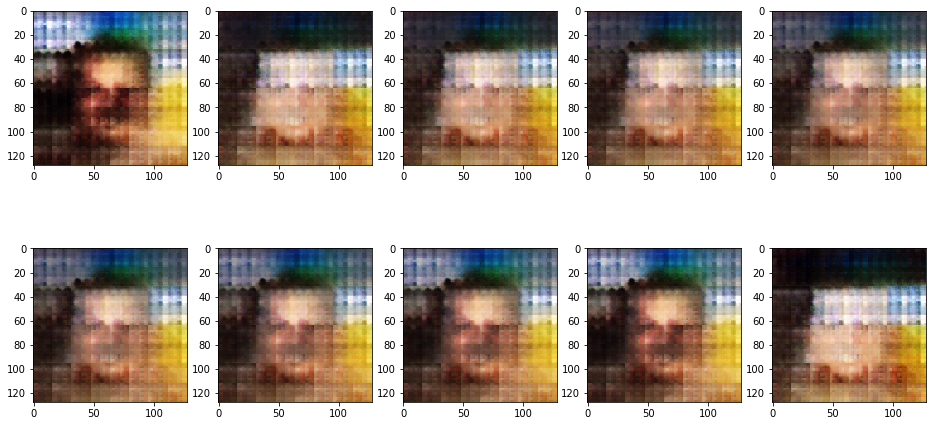

<Figure size 576x1152 with 0 Axes>

In [6]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0)

my_pic1 = model_gen(torch.randn((1,100)).cuda())
my_pic2 = model_gen(torch.randn((1,100)).cuda())
fig, axes= plt.subplots(2,5)
interp_list = []

for i in range(1,9):
    eps = .1*i
    x_hat = (eps*my_pic1) + (1-eps)*my_pic2
    interp_list.append(x_hat)

#Plot 10 images where the middle 8 are an interpolation between the first and last
axes[0,0].imshow(my_pic1.view(3,128,128).permute(1,2,0).detach())
axes[0,1].imshow(interp_list[0].view(3,128,128).permute(1,2,0).detach())
axes[0,2].imshow(interp_list[1].view(3,128,128).permute(1,2,0).detach())
axes[0,3].imshow(interp_list[2].view(3,128,128).permute(1,2,0).detach())
axes[0,4].imshow(interp_list[3].view(3,128,128).permute(1,2,0).detach())
axes[1,0].imshow(interp_list[4].view(3,128,128).permute(1,2,0).detach())
axes[1,1].imshow(interp_list[5].view(3,128,128).permute(1,2,0).detach())
axes[1,2].imshow(interp_list[6].view(3,128,128).permute(1,2,0).detach())
axes[1,3].imshow(interp_list[7].view(3,128,128).permute(1,2,0).detach())
axes[1,4].imshow(my_pic2.view(3,128,128).permute(1,2,0).detach())
plt.figure(figsize=(8,16)) 
plt.show()

Epoch:1.0000:   1%|▏         | 203/14000 [06:35<6:59:16,  1.82s/it]

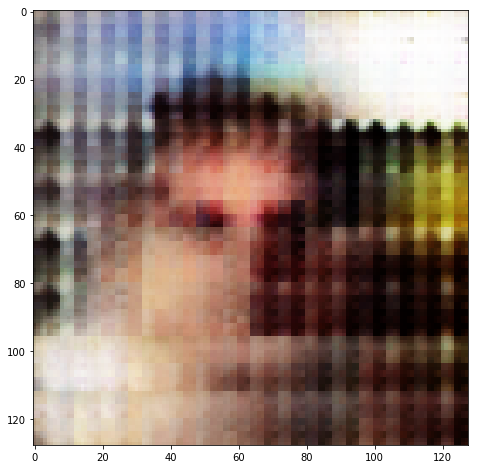

Epoch:2.0000:   3%|▎         | 403/14000 [12:53<6:59:49,  1.85s/it]

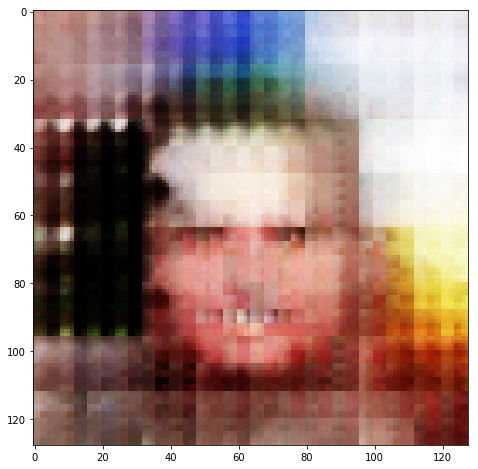

Epoch:3.0000:   4%|▍         | 603/14000 [19:48<7:39:13,  2.06s/it]

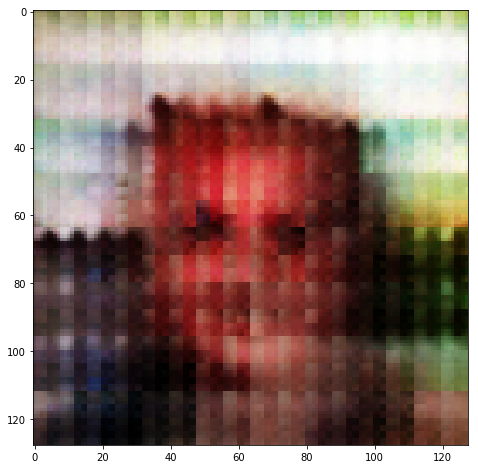

Epoch:4.0000:   6%|▌         | 803/14000 [26:55<8:21:10,  2.28s/it]

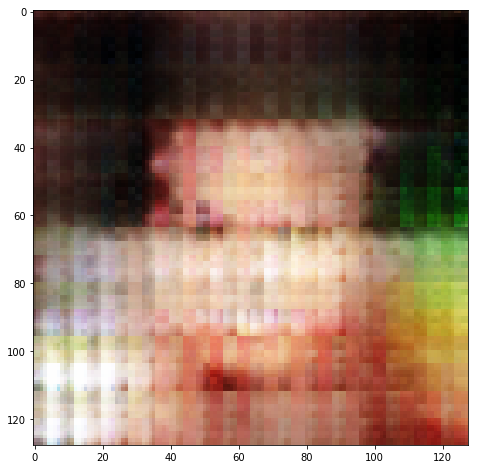

Epoch:5.0000:   7%|▋         | 1003/14000 [34:13<8:15:25,  2.29s/it]

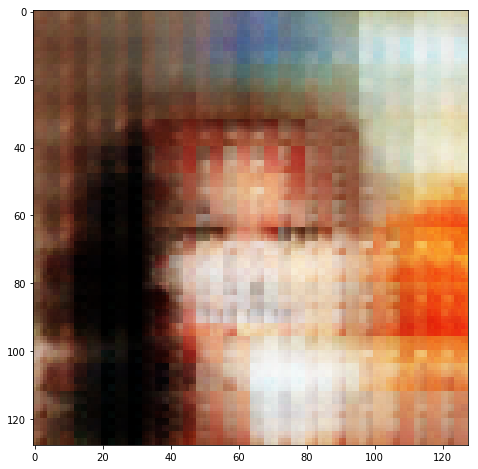

Epoch:6.0000:   9%|▊         | 1203/14000 [41:45<8:42:23,  2.45s/it] 

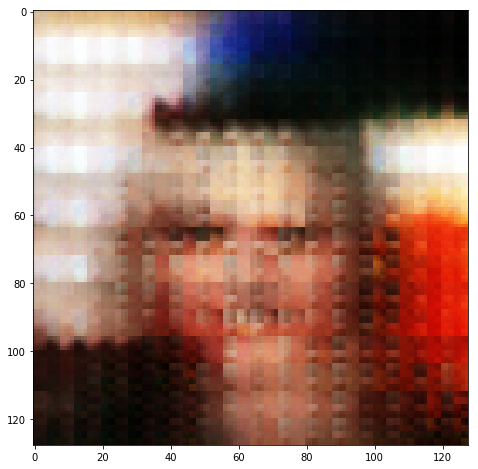

Epoch:7.0000:  10%|█         | 1403/14000 [49:17<8:21:27,  2.39s/it]

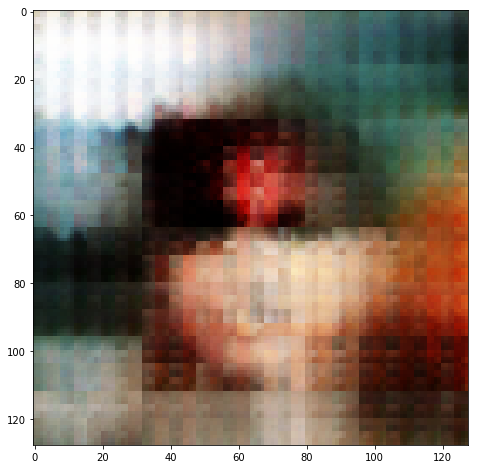

Epoch:8.0000:  11%|█▏        | 1603/14000 [56:54<8:09:19,  2.37s/it]

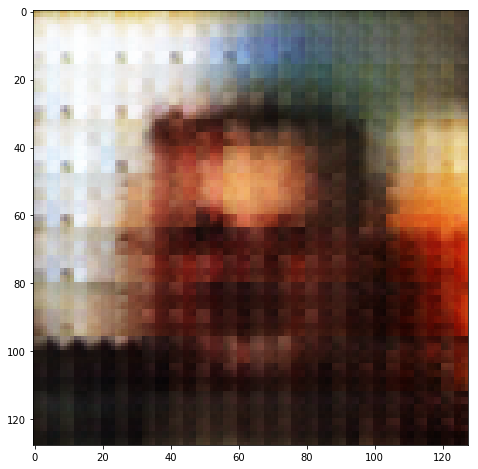

Epoch:9.0000:  13%|█▎        | 1803/14000 [1:03:16<6:15:45,  1.85s/it]

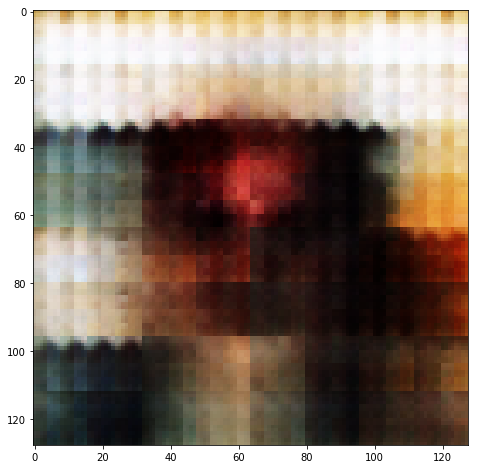

Epoch:10.0000:  14%|█▍        | 2003/14000 [1:09:26<6:09:07,  1.85s/it]

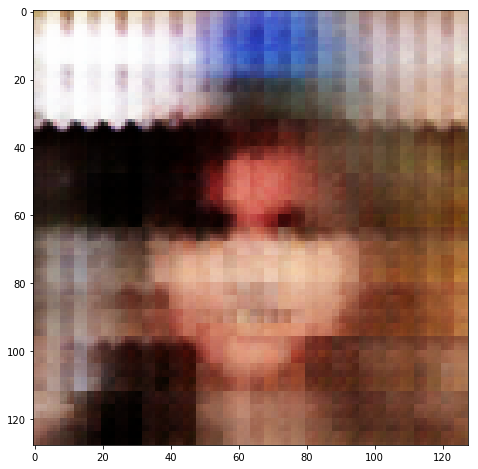

Epoch:11.0000:  16%|█▌        | 2203/14000 [1:15:36<6:02:44,  1.84s/it]

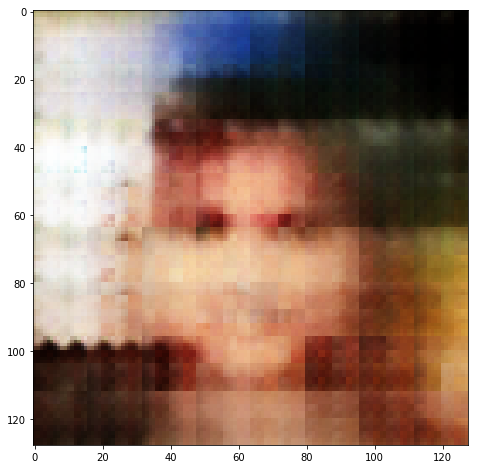

Epoch:12.0000:  17%|█▋        | 2403/14000 [1:21:46<5:55:17,  1.84s/it]

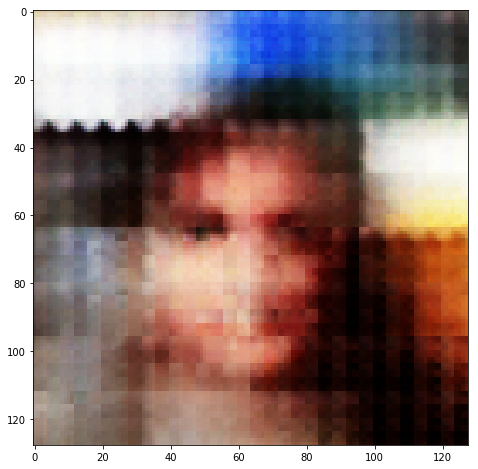

Epoch:13.0000:  19%|█▊        | 2603/14000 [1:27:57<7:12:29,  2.28s/it]

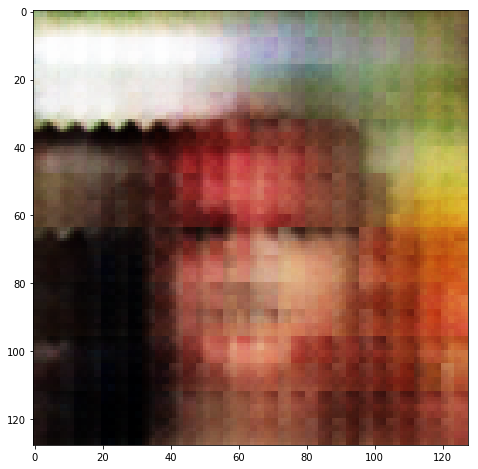

Epoch:14.0000:  20%|██        | 2803/14000 [1:34:10<5:44:15,  1.84s/it]

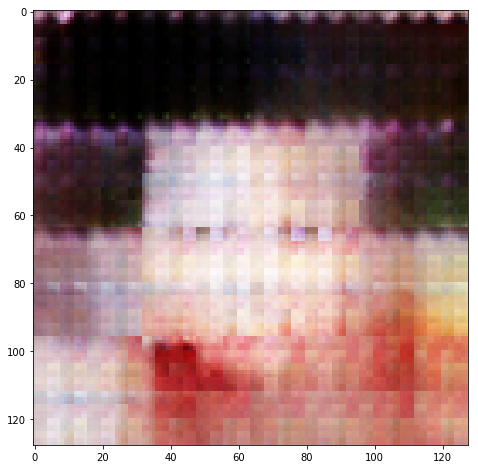

Epoch:15.0000:  21%|██▏       | 3003/14000 [1:40:18<5:37:20,  1.84s/it]

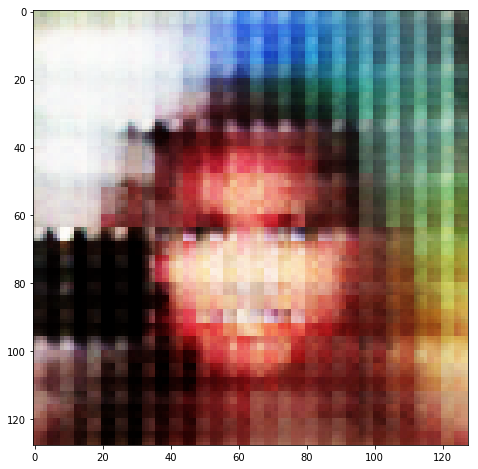

Epoch:16.0000:  23%|██▎       | 3203/14000 [1:46:27<5:32:12,  1.85s/it]

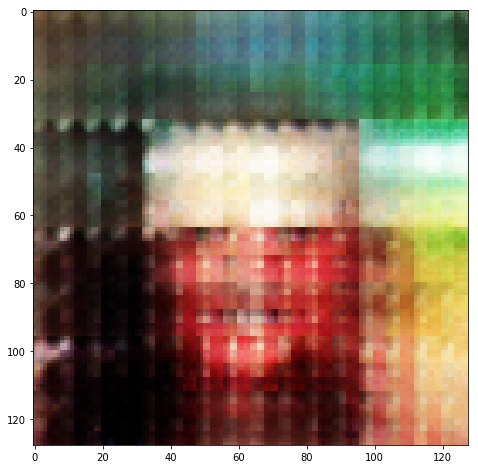

Epoch:17.0000:  24%|██▍       | 3403/14000 [1:52:35<5:26:03,  1.85s/it]

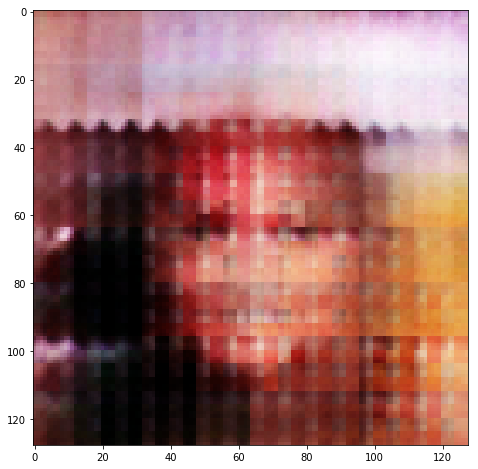

Epoch:18.0000:  26%|██▌       | 3603/14000 [1:58:44<5:18:32,  1.84s/it]

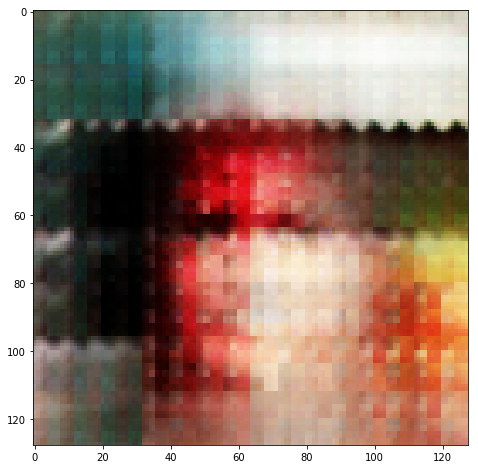

Epoch:19.0000:  27%|██▋       | 3803/14000 [2:04:52<5:13:17,  1.84s/it]

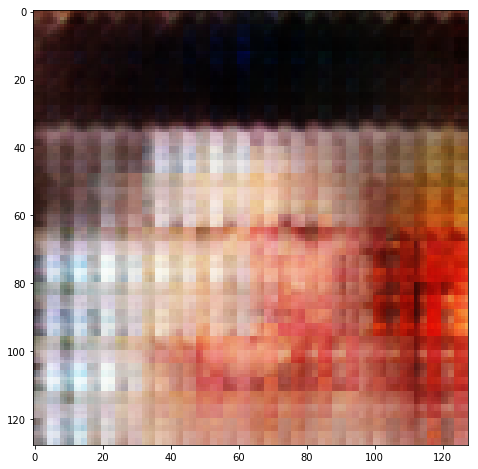

Epoch:20.0000:  29%|██▊       | 4003/14000 [2:11:00<5:06:14,  1.84s/it]

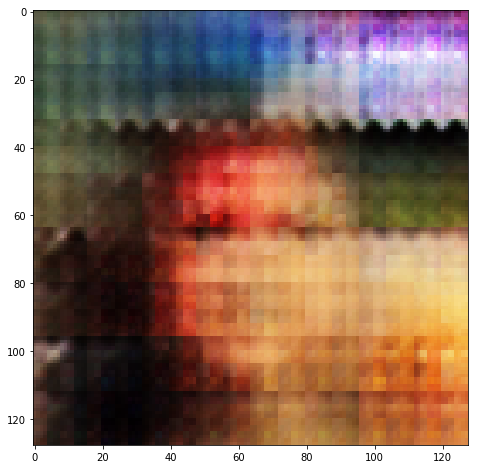

Epoch:21.0000:  30%|███       | 4203/14000 [2:17:08<5:00:30,  1.84s/it]

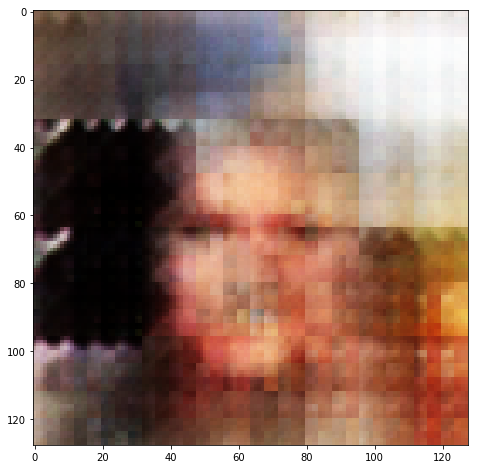

Epoch:22.0000:  31%|███▏      | 4403/14000 [2:23:17<4:55:01,  1.84s/it]

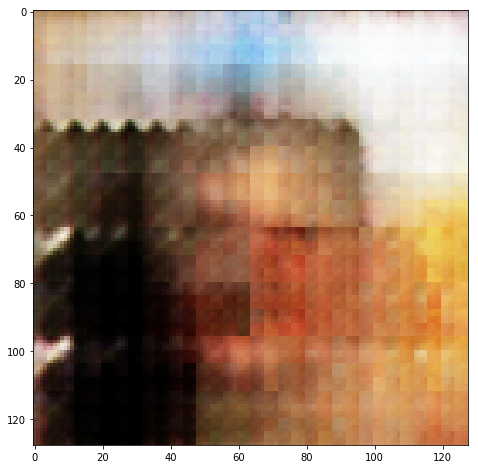

Epoch:23.0000:  33%|███▎      | 4603/14000 [2:29:26<4:49:58,  1.85s/it]

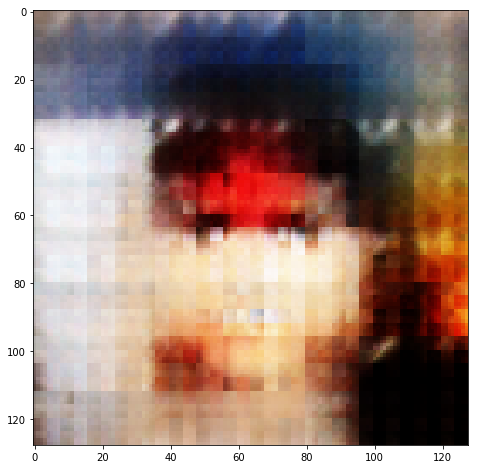

Epoch:24.0000:  34%|███▍      | 4803/14000 [2:35:37<4:43:56,  1.85s/it]

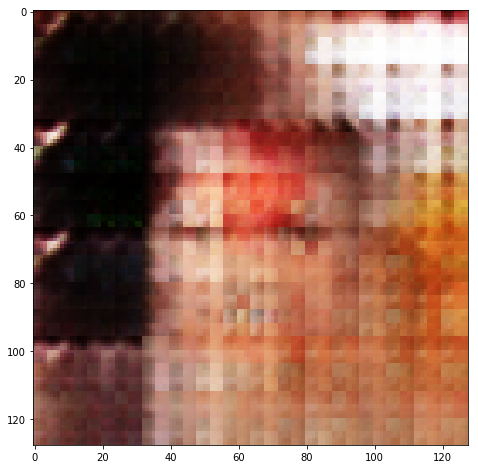

Epoch:25.0000:  36%|███▌      | 5003/14000 [2:41:46<4:36:19,  1.84s/it]

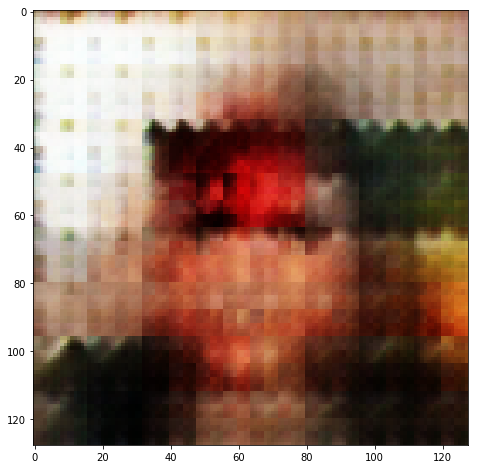

Epoch:26.0000:  37%|███▋      | 5203/14000 [2:47:54<4:30:51,  1.85s/it]

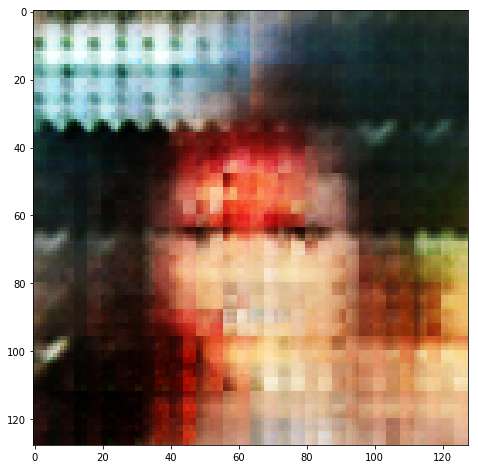

Epoch:27.0000:  39%|███▊      | 5403/14000 [2:54:03<4:24:32,  1.85s/it]

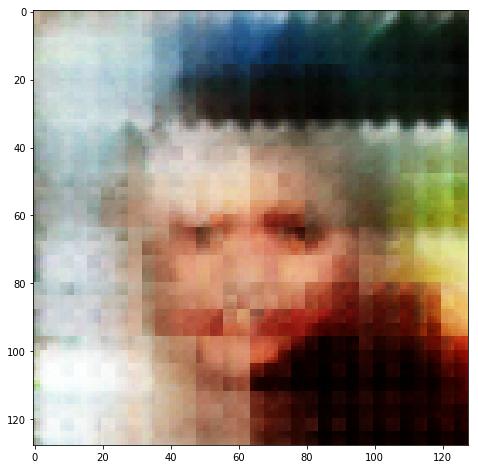

Epoch:28.0000:  40%|████      | 5603/14000 [3:00:12<4:18:08,  1.84s/it]

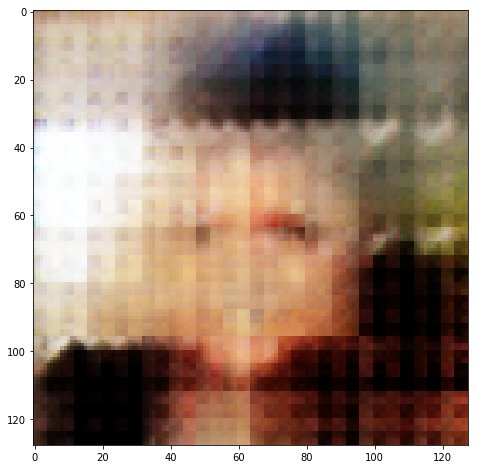

Epoch:29.0000:  41%|████▏     | 5803/14000 [3:06:21<4:11:38,  1.84s/it]

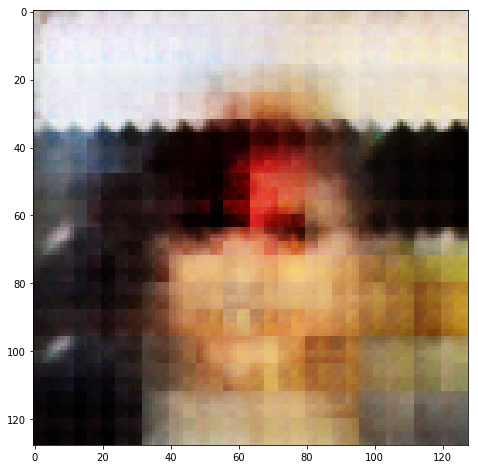

Epoch:30.0000:  43%|████▎     | 6003/14000 [3:12:29<4:05:15,  1.84s/it]

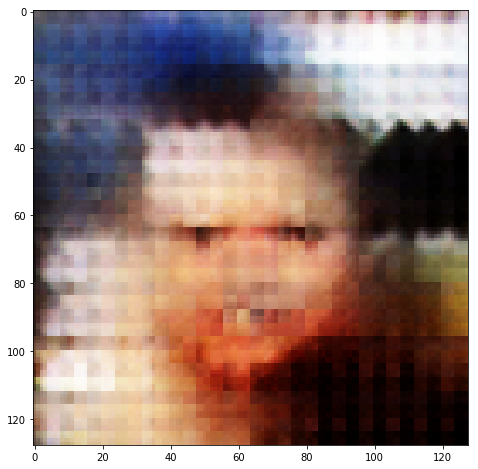

Epoch:31.0000:  44%|████▍     | 6203/14000 [3:18:37<3:58:26,  1.83s/it]

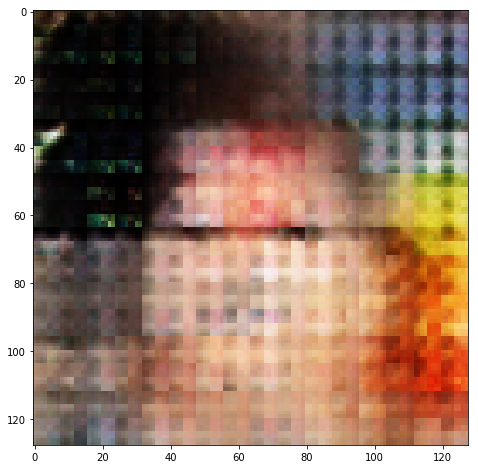

Epoch:32.0000:  46%|████▌     | 6403/14000 [3:24:44<3:52:13,  1.83s/it]

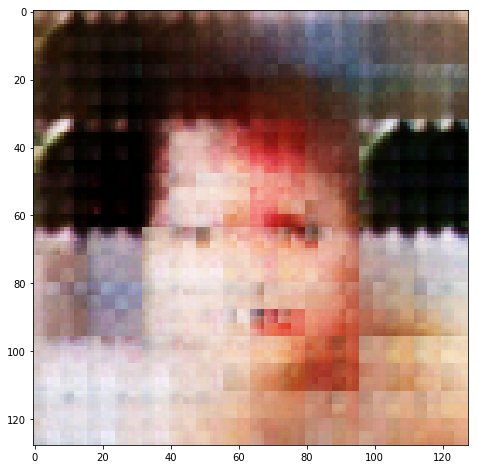

Epoch:33.0000:  47%|████▋     | 6603/14000 [3:30:51<3:45:53,  1.83s/it]

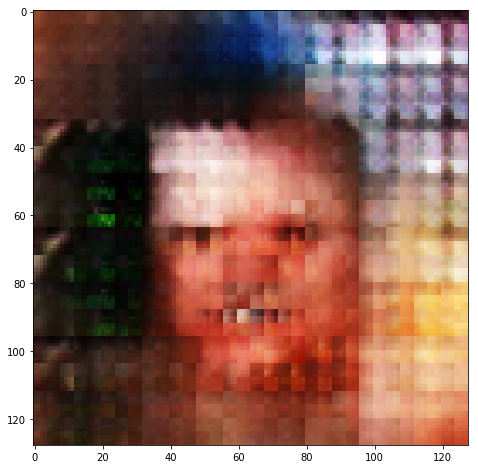

Epoch:34.0000:  49%|████▊     | 6803/14000 [3:36:58<3:39:40,  1.83s/it]

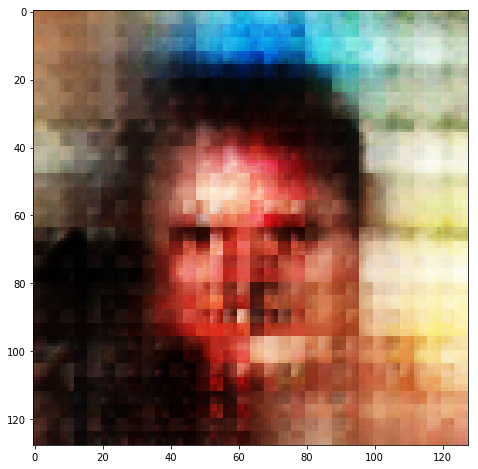

Epoch:35.0000:  50%|█████     | 7003/14000 [3:43:05<3:34:06,  1.84s/it]

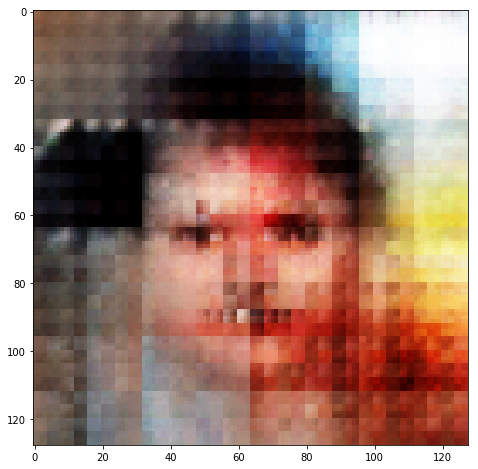

Epoch:36.0000:  51%|█████▏    | 7203/14000 [3:49:12<3:27:45,  1.83s/it]

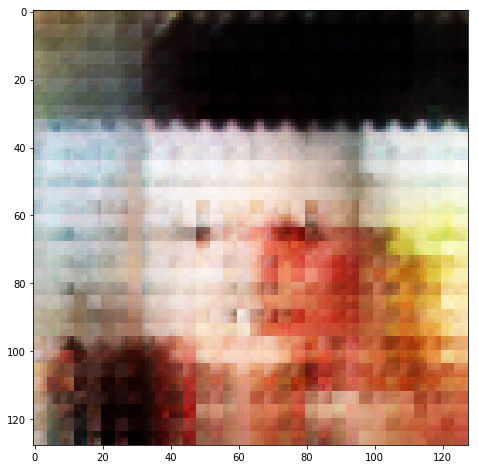

Epoch:37.0000:  53%|█████▎    | 7403/14000 [3:55:19<3:22:31,  1.84s/it]

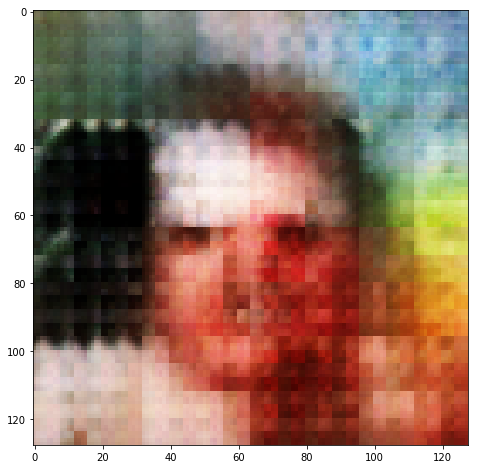

Epoch:38.0000:  54%|█████▍    | 7603/14000 [4:01:28<3:15:55,  1.84s/it]

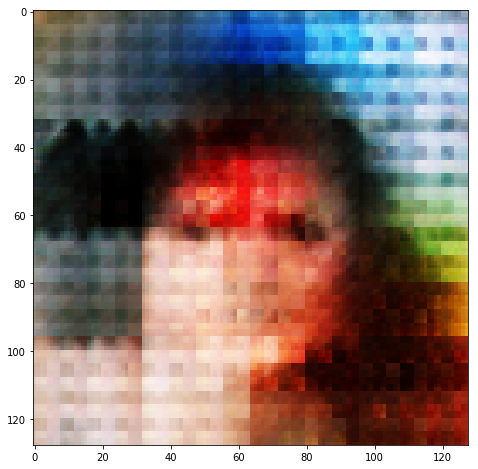

Epoch:39.0000:  56%|█████▌    | 7803/14000 [4:07:36<3:09:16,  1.83s/it]

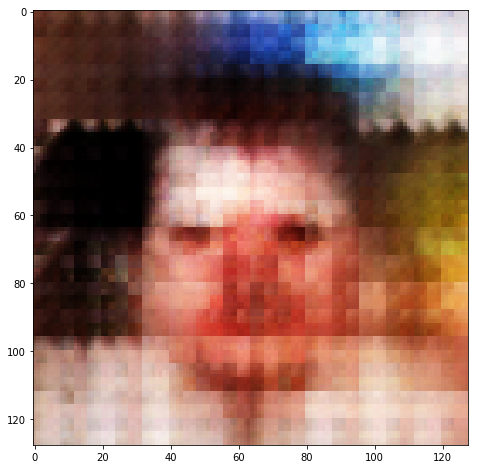

Epoch:40.0000:  57%|█████▋    | 8003/14000 [4:13:43<3:04:05,  1.84s/it]

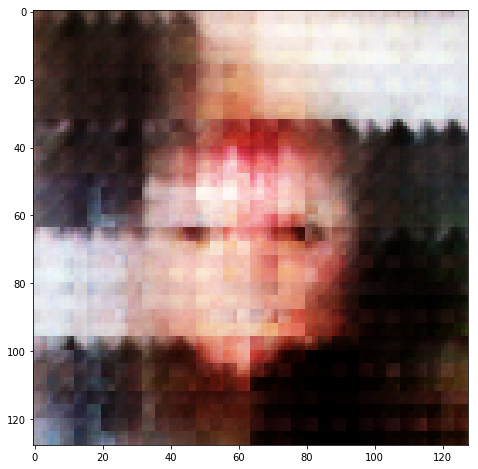

Epoch:41.0000:  59%|█████▊    | 8203/14000 [4:19:51<2:57:55,  1.84s/it]

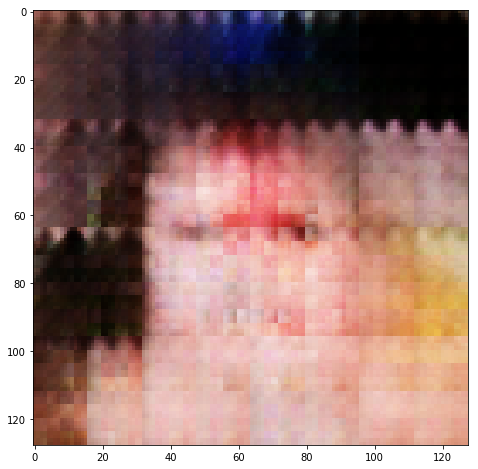

Epoch:42.0000:  60%|██████    | 8403/14000 [4:25:59<2:51:56,  1.84s/it]

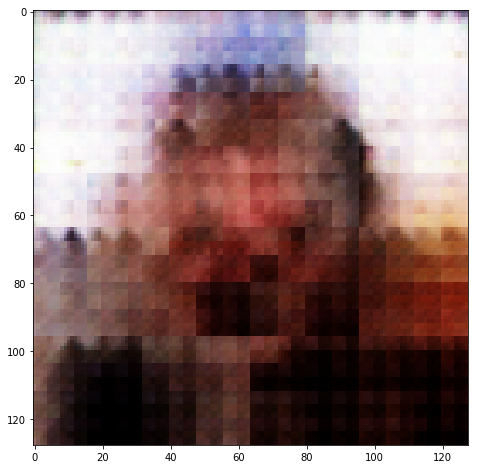

Epoch:43.0000:  61%|██████▏   | 8603/14000 [4:32:07<2:45:21,  1.84s/it]

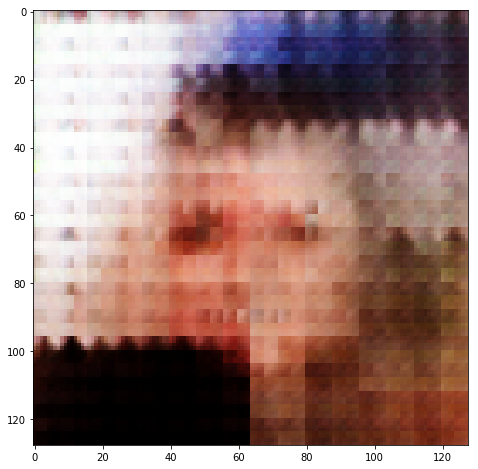

Epoch:44.0000:  63%|██████▎   | 8803/14000 [4:38:16<2:39:24,  1.84s/it]

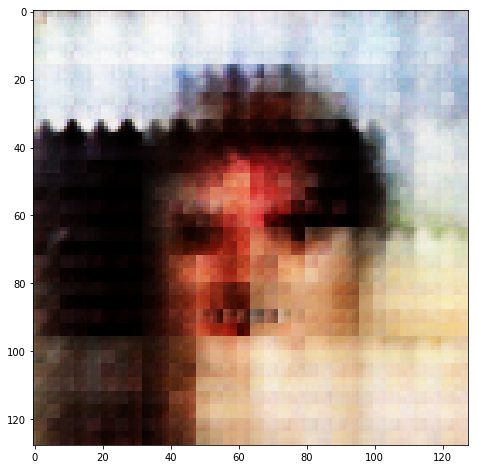

Epoch:45.0000:  64%|██████▍   | 9003/14000 [4:44:24<2:32:58,  1.84s/it]

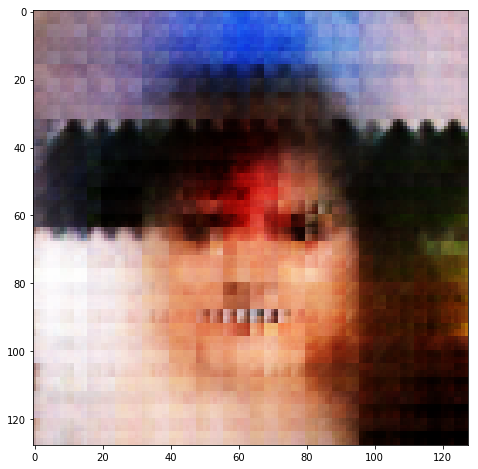

Epoch:46.0000:  66%|██████▌   | 9203/14000 [4:50:33<2:27:51,  1.85s/it]

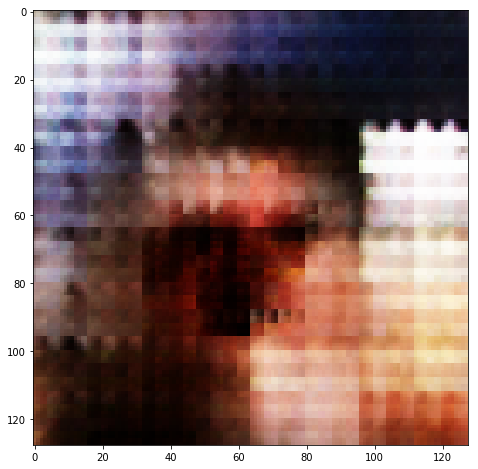

Epoch:47.0000:  67%|██████▋   | 9403/14000 [4:56:41<2:20:34,  1.83s/it]

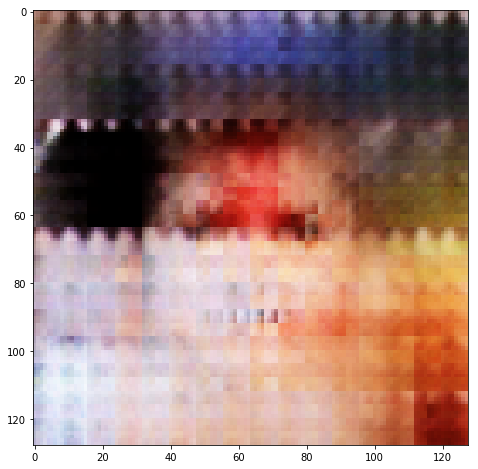

Epoch:48.0000:  69%|██████▊   | 9603/14000 [5:02:48<2:14:14,  1.83s/it]

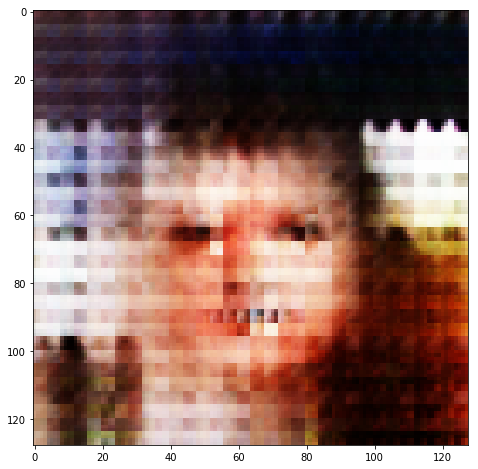

Epoch:49.0000:  70%|███████   | 9803/14000 [5:08:55<2:08:39,  1.84s/it]

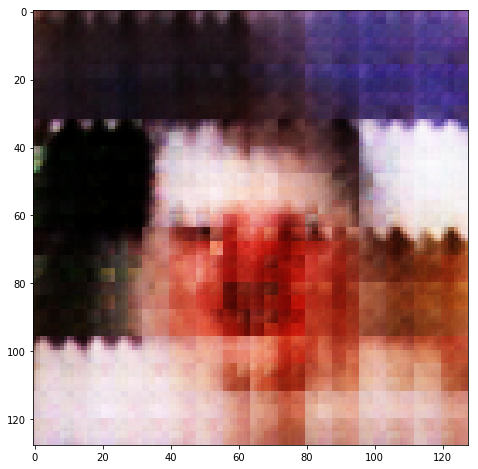

Epoch:50.0000:  71%|███████▏  | 10003/14000 [5:15:02<2:02:11,  1.83s/it]

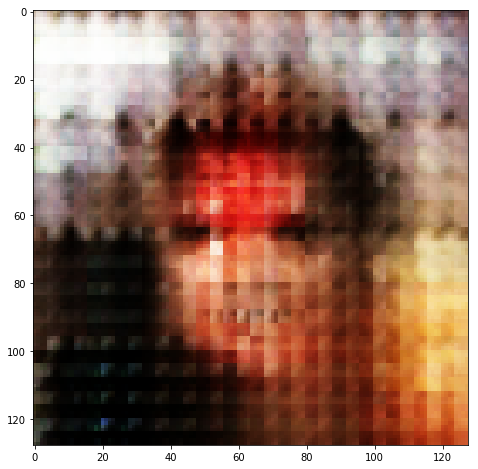

Epoch:51.0000:  73%|███████▎  | 10203/14000 [5:21:10<1:56:50,  1.85s/it]

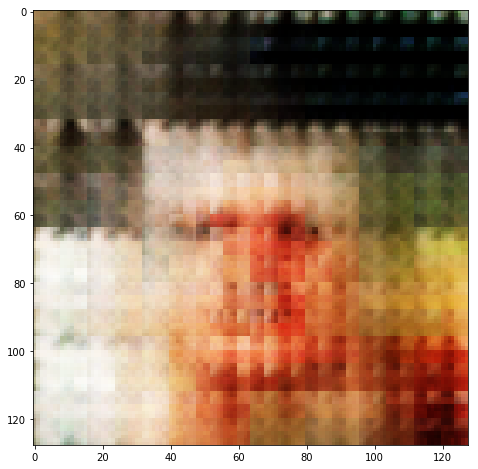

Epoch:52.0000:  74%|███████▍  | 10403/14000 [5:27:19<1:50:09,  1.84s/it]

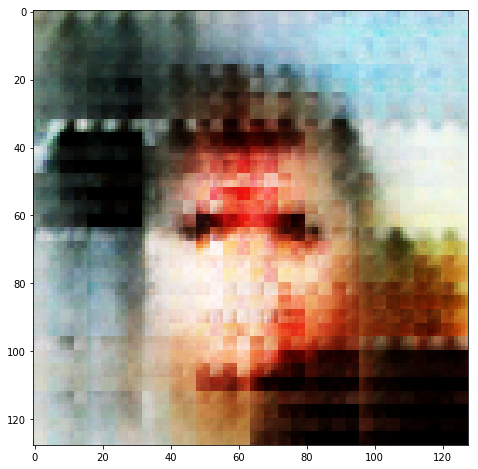

Epoch:53.0000:  76%|███████▌  | 10603/14000 [5:33:26<1:43:57,  1.84s/it]

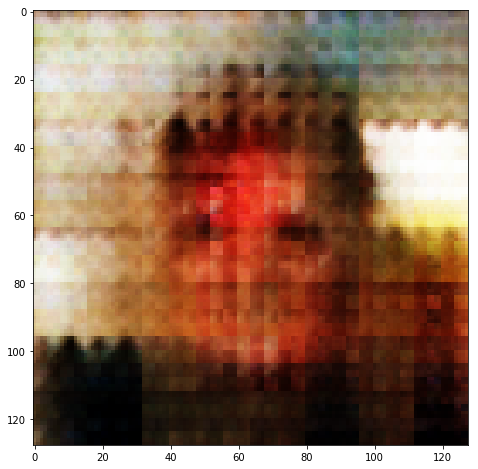

Epoch:54.0000:  77%|███████▋  | 10803/14000 [5:39:35<1:37:50,  1.84s/it]

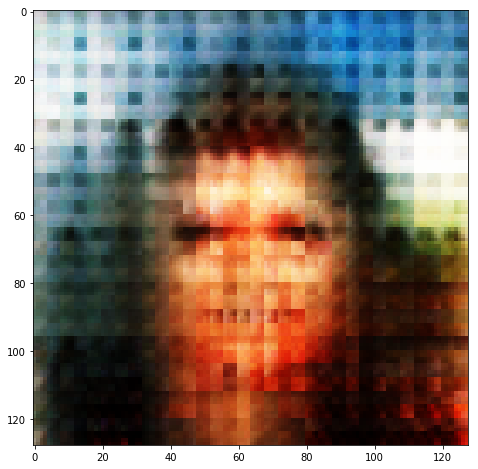

Epoch:55.0000:  79%|███████▊  | 11003/14000 [5:45:42<1:31:39,  1.83s/it]

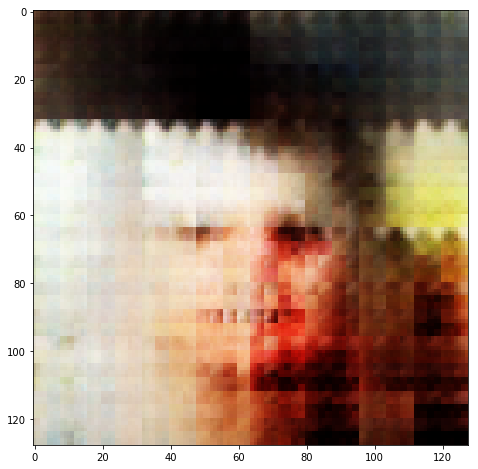

Epoch:56.0000:  80%|████████  | 11203/14000 [5:51:50<1:25:27,  1.83s/it]

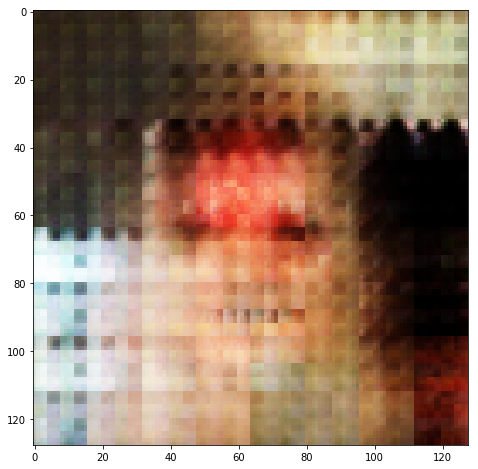

Epoch:57.0000:  81%|████████▏ | 11403/14000 [5:57:57<1:19:31,  1.84s/it]

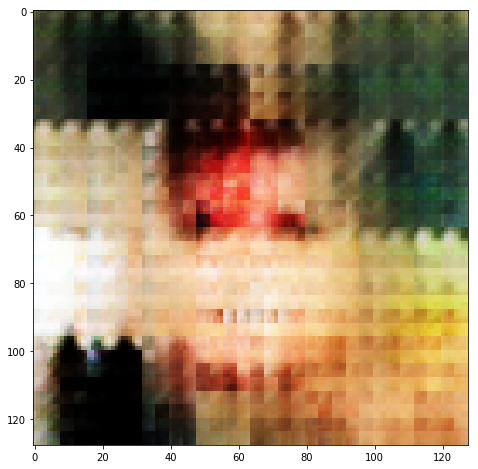

Epoch:58.0000:  83%|████████▎ | 11603/14000 [6:04:04<1:13:12,  1.83s/it]

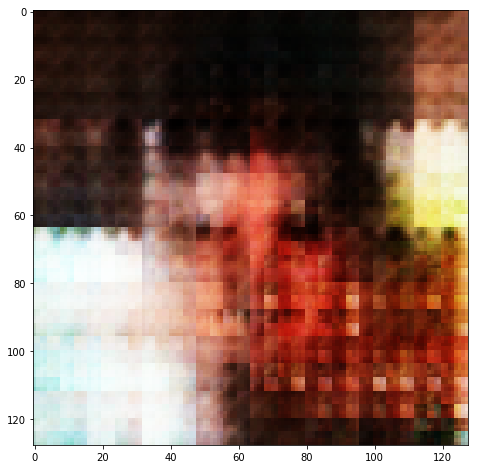

Epoch:59.0000:  84%|████████▍ | 11803/14000 [6:10:13<1:06:58,  1.83s/it]

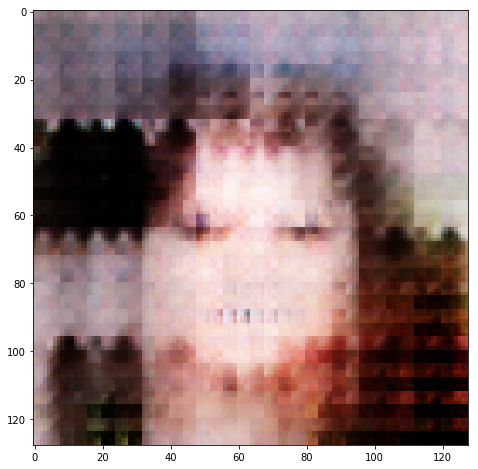

Epoch:60.0000:  86%|████████▌ | 12003/14000 [6:16:20<1:01:14,  1.84s/it]

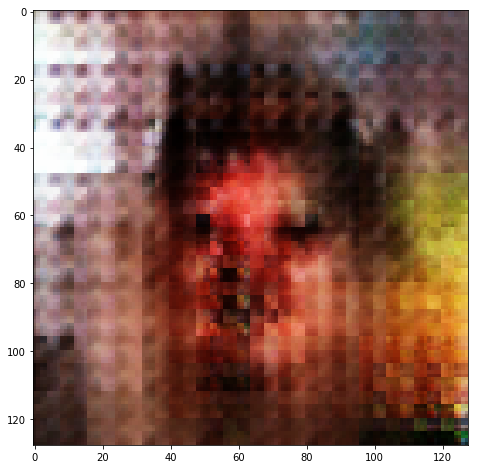

Epoch:61.0000:  87%|████████▋ | 12203/14000 [6:22:28<54:54,  1.83s/it]  

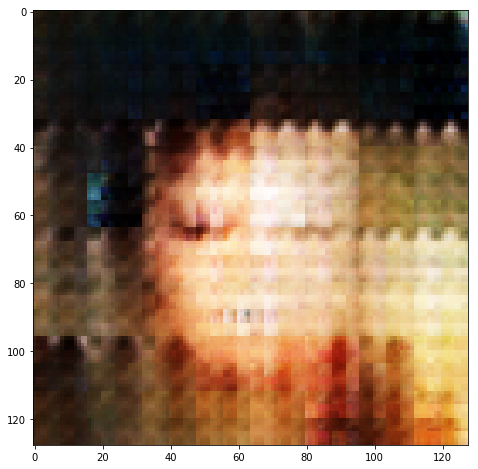

Epoch:62.0000:  89%|████████▊ | 12403/14000 [6:28:35<48:49,  1.83s/it]

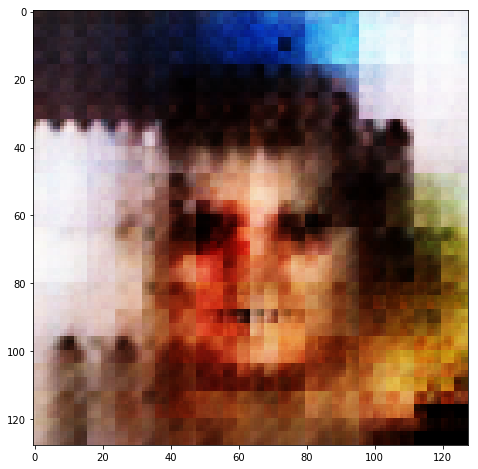

Epoch:63.0000:  90%|█████████ | 12603/14000 [6:34:42<42:42,  1.83s/it]

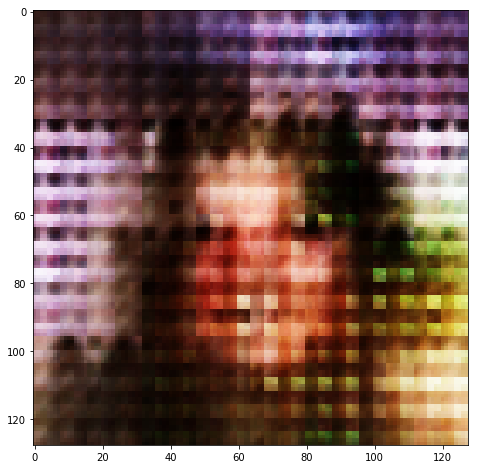

Epoch:64.0000:  91%|█████████▏| 12803/14000 [6:40:49<36:56,  1.85s/it]

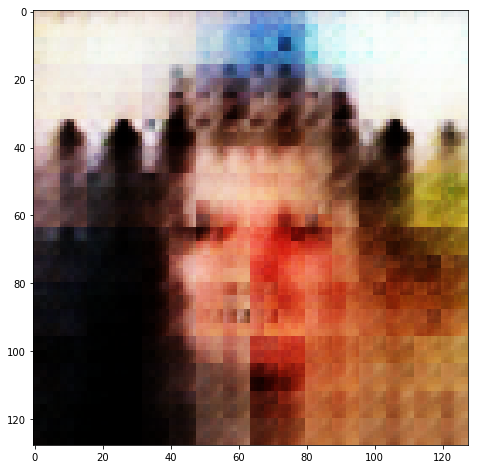

Epoch:65.0000:  93%|█████████▎| 13003/14000 [6:46:58<30:31,  1.84s/it]

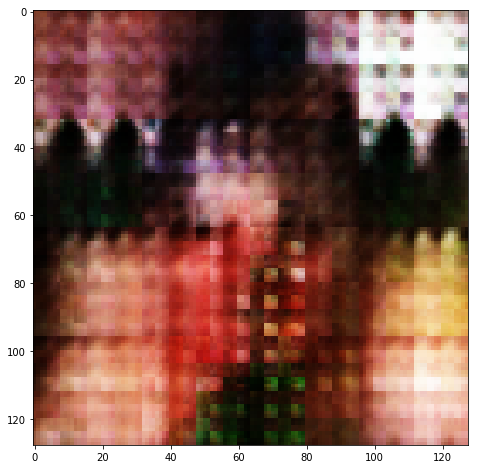

Epoch:66.0000:  94%|█████████▍| 13203/14000 [6:53:07<24:38,  1.86s/it]

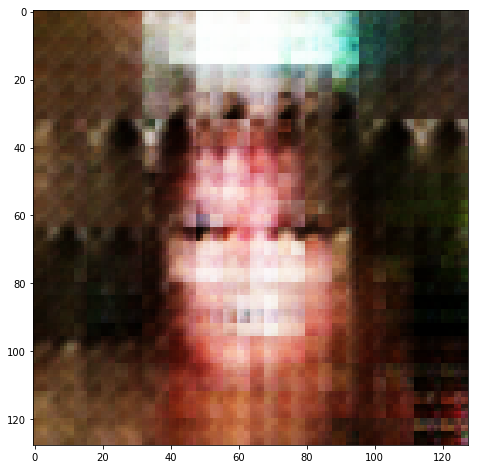

Epoch:67.0000:  96%|█████████▌| 13403/14000 [6:59:16<18:19,  1.84s/it]

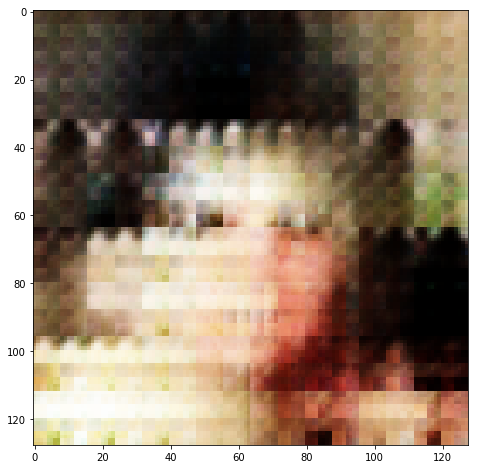

Epoch:68.0000:  97%|█████████▋| 13603/14000 [7:05:23<12:08,  1.84s/it]

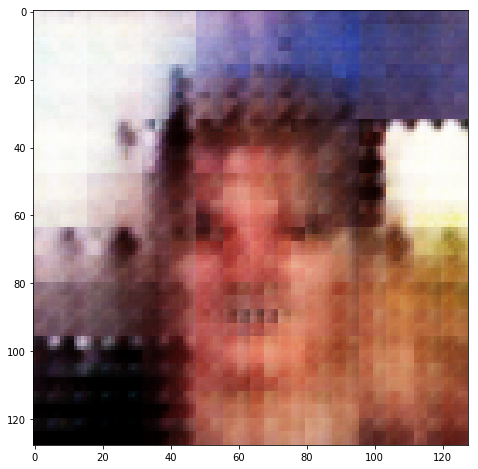

Epoch:69.0000:  99%|█████████▊| 13803/14000 [7:11:31<06:01,  1.84s/it]

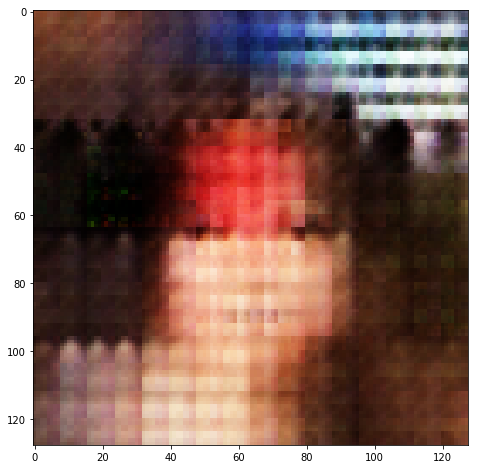

Epoch:70.0000: : 14003it [7:17:38,  1.83s/it]                         

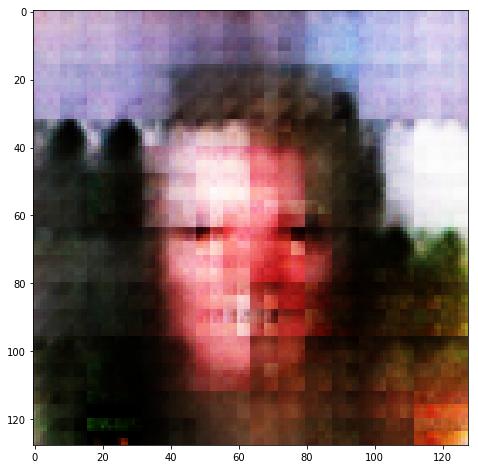

In [7]:
#This portion is used for testing. You can load the model parameters and train with new ones so you don't have 
#to start from the beginning every time.


for epoch in range(epoch_length):
    counter = 1
    for x in train_loader:
        x = x.cuda(async=True)
        gc.collect()
        if counter > 200:
            break
        for p in model_disc.parameters():
            p.requires_grad = True
        for t in range(n_critic):
            optimizer_disc.zero_grad()
            eps = torch.randn((batch_size,1), requires_grad=True)
            eps = eps.expand(batch_size, x.nelement()//batch_size)
            eps = eps.contiguous()
            eps = eps.view(batch_size, 3, 128, 128)
            eps = eps.cuda()
            z_noise = torch.randn((batch_size,100), requires_grad = True).cuda()
            x_t = model_gen(z_noise).data
            x_hat = (eps*x) + (1-eps)*x_t
            d_loss = (model_disc(x_t) - model_disc(x) + (lam*((torch.norm(autograd.grad(model_disc(x_hat),x_hat)[0])) - 1)**2))
            d_loss = torch.mean(d_loss)
            d_loss.backward()
            optimizer_disc.step()
        for p in model_disc.parameters():
            p.requires_grad = False
        optimizer_gen.zero_grad()
        z_noise = torch.randn((batch_size,100)).cuda()
        g_loss = model_disc(model_gen(z_noise))
        g_loss = -torch.mean(g_loss)
        g_loss.backward()
        optimizer_gen.step()
        loop.set_description('Epoch:{:.4f}'.format(epoch+1))
        loop.update(1)
        my_pic = model_gen(torch.randn((1,100)).cuda())
        counter +=1
    plt.imshow(my_pic.view(3,128,128).permute(1,2,0).detach())
    plt.show()
        




loop.close() 